In [3]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import collections
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download('punkt')

import nltk
nltk.download('stopwords')

from wordcloud import WordCloud

!pip install unidecode

from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#Advance Data Processing & Hyperparameter Optimization
from sklearn.decomposition import PCA
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 11.2 MB/s eta 0:00:00


In [4]:
# Load Dataset
data = pd.read_csv('/content/Stress.csv')

In [5]:
#Exploratory Data Analysis (EDA)
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,2838.0,5.243129e-01,4.994965e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
confidence,2838.0,8.089718e-01,1.770383e-01,4.285714e-01,6.000000e-01,8.000000e-01,1.000000e+00,1.000000e+00
social_timestamp,2838.0,1.518107e+09,1.552209e+07,1.483274e+09,1.509698e+09,1.517066e+09,1.530898e+09,1.542592e+09


In [8]:
# Check Null Values
data.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [9]:
 # Data Cleaning
def clean(data_frame):
    # Variable to replace all characters that are not letters or whitespace
    regex = re.compile('[^a-z\s]')
    
    # Convert text to lower case
    data_frame['clean_text'] = data_frame['text'].str.lower()
    # Removes all characters that are not letters or spaces
    data_frame['clean_text'] = data_frame['clean_text'].apply(lambda x: regex.sub('', x))
    # Removes all characters between square brackets
    data_frame['clean_text'] = data_frame['clean_text'].str.replace('[%s]', '', regex = True)
    # Remove the accents
    data_frame['clean_text'] = data_frame['clean_text'].apply(lambda x: regex.sub('', unidecode(x)))
    # Remove http
    data_frame['clean_text'] = data_frame['clean_text'].str.replace('http', '', regex = True)
    # Remove words with less than 3 characters
    data_frame['clean_text'] = data_frame['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
    
    # Tokenization
    data_frame['clean_text'] = data_frame['clean_text'].apply(word_tokenize)
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    data_frame['clean_text'] = data_frame['clean_text'].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Word normalization
    stemmer = SnowballStemmer('english')
    data_frame['clean_text'] = data_frame['clean_text'].apply(lambda x: [stemmer.stem(word) for word in x])
    # Joining the words back into a single text
    data_frame['clean_text'] = data_frame['clean_text'].apply(lambda x: ' '.join(x))
    
    return data_frame

In [10]:
 # Create Variable and store dataset
clean_data = clean(data)

In [11]:
clean_data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,clean_text
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353,aid felt way ugget ret trigger ahead youir hyp...
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,hey raitanc ure thi right place pot thi goe cu...
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605,mom hit newpap hock would thi know dont like p...
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,met new boyfriend amaz kind weet good tudent l...
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005,octob domet violenc awaren month domet violenc...


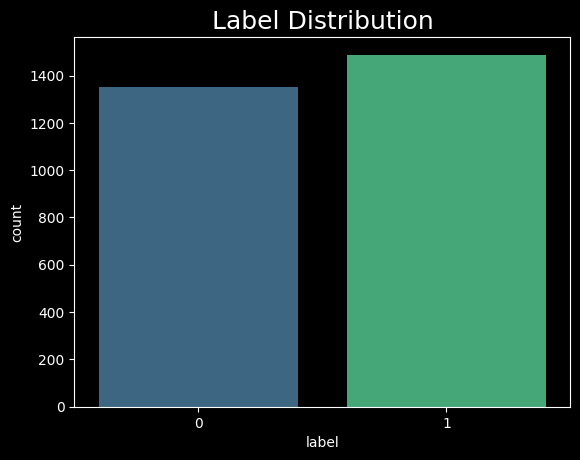

In [12]:
plt.style.use('dark_background')                            # Dark Background
sns.countplot(x = clean_data['label'], palette = 'viridis') # Create the Countplot
plt.title('Label Distribution', fontsize = 18);             # Title 

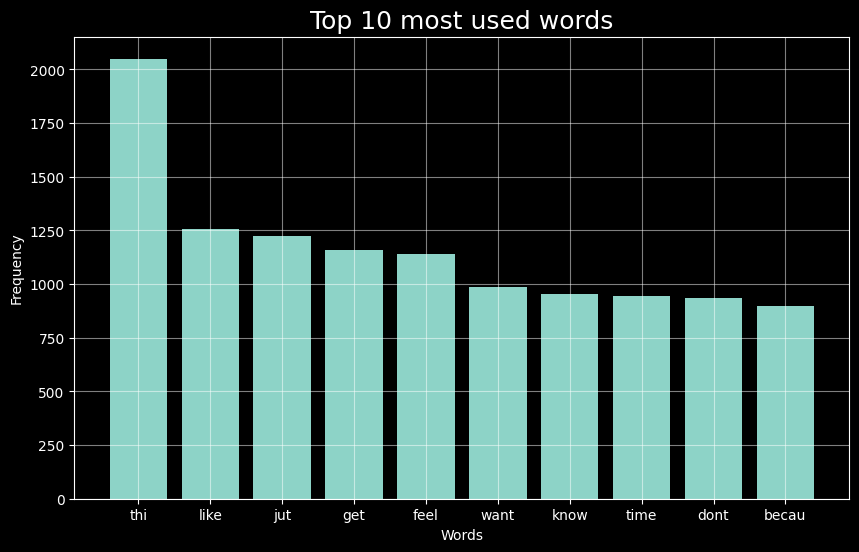

In [13]:
# Top 10 most used words

words = []
for text in clean_data['clean_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

plt.style.use('dark_background')                                           # Dark Background
plt.figure(figsize = (10, 6))                                              # Figure Size
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center') # Create the Barplot
plt.xticks(range(len(top_words)), list(top_words.keys()))                  # Creating a y axis with words
plt.grid(alpha = 0.5)                                                      # Grid Opacity
plt.title('Top 10 most used words', fontsize = 18)                         # Grid Opacity
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show();


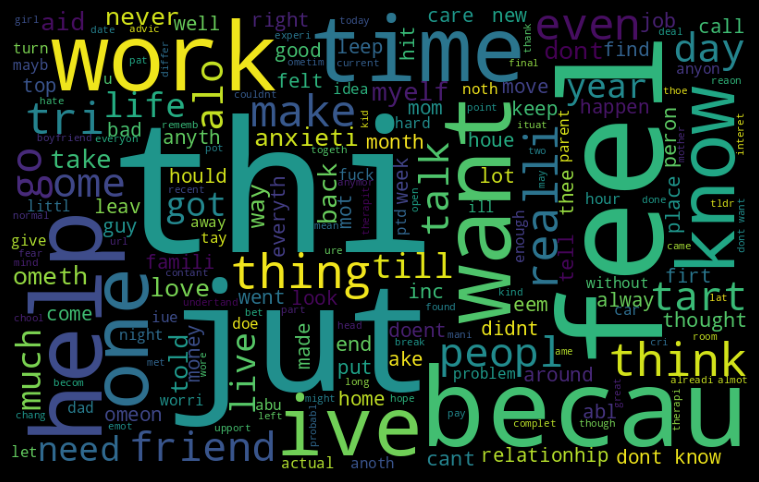

In [14]:
# Word Cloud
# Concatenating all cleaned texts into a single string
text = ' '.join(caption for caption in clean_data['clean_text'])
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', min_font_size = 10).generate(text) 
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud)   
plt.axis('off') 
plt.show();

<ipython-input-15-e8b391023571>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True)


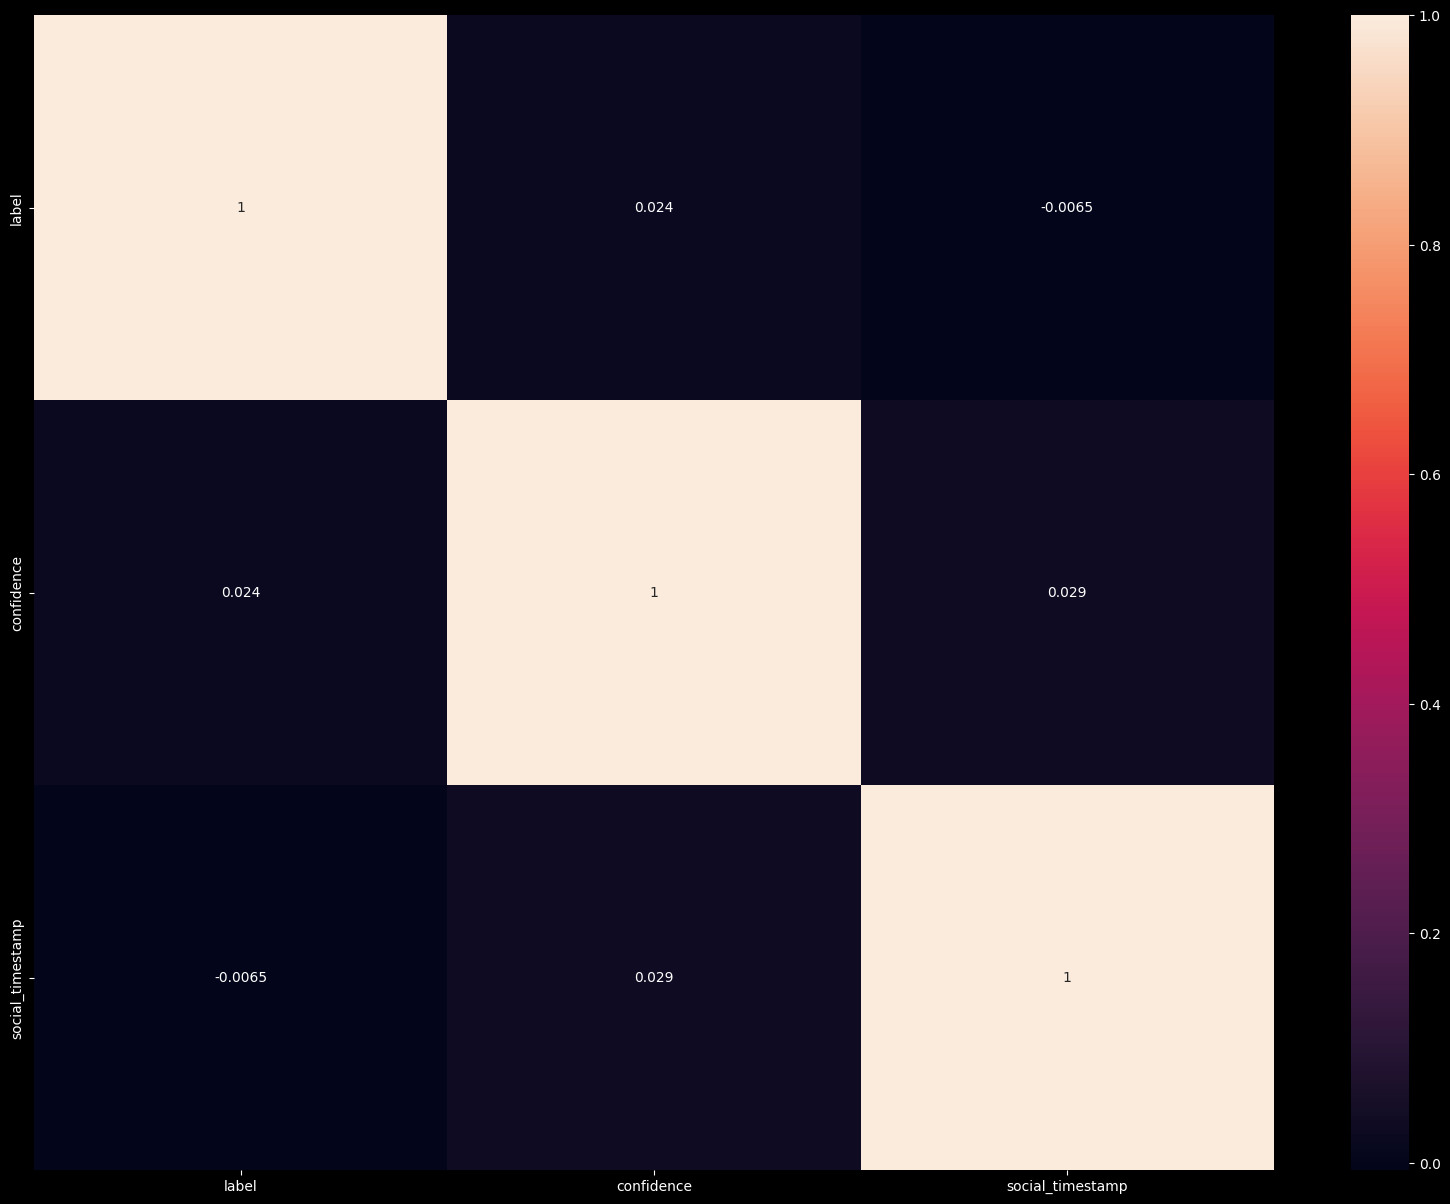

In [15]:
#Finding out the correlation
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(),annot=True)
plt.show()

In [16]:
# Renaming label column values
clean_data['new_label'] = clean_data['label'].map({0: 'No Stress', 1: 'Stress'})

In [17]:
# Split X and Y
x = np.array(clean_data['clean_text'])
y = np.array(clean_data['new_label'])

cv = CountVectorizer() # Convert text to numerical
X = cv.fit_transform(x)

# Split Train and Test
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 31)

In [18]:
# Models
MNB = MultinomialNB()
BNB = BernoulliNB()
SVM = SVC()

In [19]:
MNB.fit(xtrain, ytrain)
BNB.fit(xtrain, ytrain)
SVM.fit(xtrain, ytrain)

SVC()

In [22]:
# Predictions
pred_mnb = MNB.predict(xtest)
pred_bnb = BNB.predict(xtest)
pred_svm = SVM.predict(xtest)

In [23]:
# classification report of MultinomialNB 
print('*' * 55)
print(f'Multinomia Accuracy: {accuracy_score(ytest, pred_mnb)}')
print('*' * 55)
print(classification_report(ytest, pred_mnb))

*******************************************************
Multinomia Accuracy: 0.7869718309859155
*******************************************************
              precision    recall  f1-score   support

   No Stress       0.80      0.70      0.75       255
      Stress       0.78      0.86      0.82       313

    accuracy                           0.79       568
   macro avg       0.79      0.78      0.78       568
weighted avg       0.79      0.79      0.79       568



In [24]:
# Classification report BernoulliNB
print('*' * 55)
print(f'Bernoulli Accuracy: {accuracy_score(ytest, pred_bnb)}')
print('*' * 55)
print(classification_report(ytest, pred_bnb))

*******************************************************
Bernoulli Accuracy: 0.772887323943662
*******************************************************
              precision    recall  f1-score   support

   No Stress       0.77      0.71      0.74       255
      Stress       0.78      0.83      0.80       313

    accuracy                           0.77       568
   macro avg       0.77      0.77      0.77       568
weighted avg       0.77      0.77      0.77       568



In [25]:
# Classification report SVM
print('*' * 55)
print(f'SVM Accuracy: {accuracy_score(ytest, pred_svm)}')
print('*' * 55)
print(classification_report(ytest, pred_svm))

*******************************************************
SVM Accuracy: 0.7288732394366197
*******************************************************
              precision    recall  f1-score   support

   No Stress       0.68      0.74      0.71       255
      Stress       0.77      0.72      0.75       313

    accuracy                           0.73       568
   macro avg       0.73      0.73      0.73       568
weighted avg       0.73      0.73      0.73       568

